shape of x (100, 1)
Train Epoch: 0 	Loss eqn: 0.0016077448 Loss data: 0.6940560341
learning rate is  0.001
Train Epoch: 10 	Loss eqn: 0.0389310494 Loss data: 0.0162570495
learning rate is  0.001
Train Epoch: 20 	Loss eqn: 0.0644852743 Loss data: 0.0109021720
learning rate is  0.001
Train Epoch: 30 	Loss eqn: 0.0389151201 Loss data: 0.0122379716
learning rate is  0.001
Train Epoch: 40 	Loss eqn: 0.0550070070 Loss data: 0.0099612009
learning rate is  0.001
Train Epoch: 50 	Loss eqn: 0.0553533435 Loss data: 0.0097460952
learning rate is  0.001
Train Epoch: 60 	Loss eqn: 0.0471335202 Loss data: 0.0105041219
learning rate is  0.001
Train Epoch: 70 	Loss eqn: 0.0544231646 Loss data: 0.0097527718
learning rate is  0.001
Train Epoch: 80 	Loss eqn: 0.0497051477 Loss data: 0.0102068232
learning rate is  0.001
Train Epoch: 90 	Loss eqn: 0.0528935790 Loss data: 0.0098756254
learning rate is  0.001
Train Epoch: 100 	Loss eqn: 0.0523123331 Loss data: 0.0099304952
learning rate is  0.001
Train Epoch:

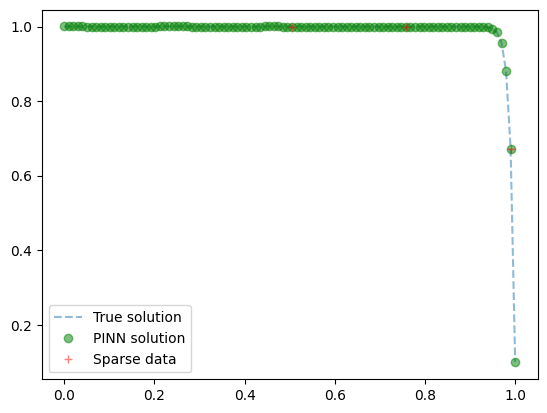

In [8]:
import torch
import numpy as np
#import foamFileOperation
from matplotlib import pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pdb
#from torchvision import datasets, transforms
import csv
from torch.utils.data import DataLoader, TensorDataset,RandomSampler
from math import exp, sqrt,pi
import time
import math

# https://github.com/amir-cardiolab/PINN-wss/blob/main/1D-advection-diffusion/myPINN_1d_nwall2.py

def geo_train(device,x_in,xb,cb,batchsize,learning_rate,epochs,path,Flag_batch,C_analytical,Vel,Diff):
	if (Flag_batch):
		x = torch.Tensor(x_in)	
		dataset = TensorDataset(x,x)
		dataloader = DataLoader(dataset, batch_size=batchsize,shuffle=True,num_workers = 0,drop_last = False )
	else:
		x = torch.Tensor(x_in)  
		h_n = 100 
		input_n = 1 # this is what our answer is a function of. 
		class Swish(nn.Module):
			def __init__(self, inplace=True):
				super(Swish, self).__init__()
				self.inplace = inplace

			def forward(self, x):
				if self.inplace:
					x.mul_(torch.sigmoid(x))
					return x
				else:
					return x * torch.sigmoid(x)
		
		class Net2(nn.Module):

			#The __init__ function stack the layers of the 
			#network Sequentially 
			def __init__(self):
				super(Net2, self).__init__()
				self.main = nn.Sequential(
					nn.Linear(input_n,h_n),
					#nn.Tanh(),
					#nn.Sigmoid(),
					Swish(),
					nn.Linear(h_n,h_n),
					#nn.Tanh(),
					#nn.Sigmoid(),
					Swish(),
					nn.Linear(h_n,h_n),
					#nn.Tanh(),
					#nn.Sigmoid(),


					Swish(),
					nn.Linear(h_n,h_n),


					Swish(),
					nn.Linear(h_n,h_n),

					Swish(),
					nn.Linear(h_n,h_n),

					Swish(),
					nn.Linear(h_n,h_n),

					Swish(),
					nn.Linear(h_n,h_n),

					Swish(),

					#######
					nn.Linear(h_n,h_n),

					Swish(),


					nn.Linear(h_n,h_n),

					Swish(),


					#######
					#nn.Linear(h_n,h_n),

					#Swish(),
					
					#nn.Linear(h_n,h_n),

					#Swish(),



					nn.Linear(h_n,1),
				)
			#This function defines the forward rule of
			#output respect to input.
			def forward(self,x):
				output = self.main(x)
				if (Flag_BC_near_wall):
					#output = output*x*(1-x) + (-0.9*x + 1.) #modify output to satisfy BC automatically #PINN-transfer-learning-BC-20
					return  output * (1-x) + 0.1 #enforce BC at the wall region of interest
				else:
					return  output #* (x) + 1.0
					
	
	################################################################

	net2 = Net2().to(device)
	
	def init_normal(m):
		if type(m) == nn.Linear:
			nn.init.kaiming_normal_(m.weight)

	# use the modules apply function to recursively apply the initialization
	net2.apply(init_normal)


	############################################################################

	optimizer2 = optim.Adam(net2.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
	

	def criterion(x):

		#print (x)
		#x = torch.Tensor(x).to(device)
	

		x.requires_grad = True
		

		net_in = x
		C = net2(net_in)
		C = C.view(len(C),-1)



		
		c_x = torch.autograd.grad(C,x,grad_outputs=torch.ones_like(x),create_graph = True,only_inputs=True)[0]
		c_xx = torch.autograd.grad(c_x,x,grad_outputs=torch.ones_like(x),create_graph = True,only_inputs=True)[0]
		
		loss_1 = Vel * c_x - Diff * c_xx




		# MSE LOSS
		loss_f = nn.MSELoss()

		#Note our target is zero. It is residual so we use zeros_like
		loss = loss_f(loss_1,torch.zeros_like(loss_1)) 

		return loss

	###################################################################
	def Loss_BC(xb,cb):
		xb = torch.FloatTensor(xb).to(device)
		cb = torch.FloatTensor(cb).to(device)

		#xb.requires_grad = True
		
		#net_in = torch.cat((xb),1)
		out = net2(xb)
		cNN = out.view(len(out), -1)
		#cNN = cNN*(1.-xb) + cb    #cNN*xb*(1-xb) + cb
		loss_f = nn.MSELoss()
		loss_bc = loss_f(cNN, cb)
		return loss_bc

		###################################################################
	def Loss_data(xd,cd):
		xd = torch.FloatTensor(xd).to(device)
		cd = torch.FloatTensor(cd).to(device)

		#xb.requires_grad = True
		

		out = net2(xd)
		out = out.view(len(out), -1)
		loss_f = nn.MSELoss()
		loss_bc = loss_f(out, cd)

		return loss_bc



	# Main loop
	LOSS = []
	tic = time.time()



	xd = x_in[ [ int(nPt/2), int(3*nPt/4), int(9.8*nPt/10)    ] ] 
	cd = C_analytical[ [ int(nPt/2), int(3*nPt/4), int(9.8*nPt/10)   ] ]


	if (Flag_schedule):
		scheduler_c = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=step_epoch, gamma=decay_rate)


	if(Flag_batch):# This one uses dataloader
		for epoch in range(epochs):
			for batch_idx, (x_in2,x_in2) in enumerate(dataloader):
				#zero gradient
				#net1.zero_grad()
				##Closure function for LBFGS loop:
				#def closure():
				net2.zero_grad()
				#x_in2 = torch.FloatTensor(x_in2)
				#print (x_in2)
				#print (x)
				#print('shape of x_in2',x_in2.shape)
				loss_eqn = criterion(x_in2)
				loss_data = Loss_data(xd,cd)
				loss = loss_eqn + Lambda_data * loss_data
				loss.backward()
		
				optimizer2.step() 
			if (Flag_schedule):
					scheduler_c.step()

			if epoch % 10  ==0:
					#print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.10f}'.format(
					#	epoch, batch_idx * len(x), len(dataloader.dataset),
					#	100. * batch_idx / len(dataloader), loss.item()))
					print('Train Epoch: {} \tLoss eqn: {:.10f} Loss data: {:.10f}'.format(
					epoch, loss_eqn.item(), loss_data.item()))
					if (Flag_schedule):
						print('learning rate is ', optimizer2.param_groups[0]['lr'])
				#if epoch %100 == 0:
				#	torch.save(net2.state_dict(),path+"geo_para_axisy_sigma"+str(sigma)+"_epoch"+str(epoch)+"hard_u.pt")
	else:
		for epoch in range(epochs):
			#zero gradient
			#net1.zero_grad()
			##Closure function for LBFGS loop:
			#def closure():
			net2.zero_grad()
			loss_eqn = criterion(x.to(device))
			#loss_bc = Loss_BC(xb,cb)
			loss_data = Loss_data(xd,cd)
			loss = loss_eqn + Lambda_data * loss_data
			
			loss.backward()

			optimizer2.step() 
			
			if (Flag_schedule):
				scheduler_c.step()

			if epoch % 10 ==0:
				print('Train Epoch: {} \tLoss eqn: {:.10f} Loss data: {:.10f}'.format(
					epoch, loss_eqn.item(), loss_data.item()))
				if (Flag_schedule):
					print('learning rate is ', optimizer2.param_groups[0]['lr'])
		

	toc = time.time()
	elapseTime = toc - tic
	print ("elapse time in parallel = ", elapseTime)
	###################
	#plot
	output = net2(x.to(device))  #evaluate model
	C_Result = output.cpu().data.numpy()
	plt.figure()
	plt.plot(x.cpu().detach().numpy(), C_analytical[:], '--', label='True solution', alpha=0.5) #analytical
	plt.plot(x.cpu().detach().numpy() , C_Result, 'go', label='PINN solution', alpha=0.5) #PINN
	plt.plot(xd[:], cd[:], 'r+', label='Sparse data', alpha=0.5) #data pts
	plt.legend(loc='best')
	plt.show()

	return net2

	############################################################
	##save loss
	##myFile = open('Loss track'+'stenosis_para'+'.csv','w')#
	##with myFile:
		#writer = csv.writer(myFile)
		#writer.writerows(LOSS)
	#LOSS = np.array(LOSS)
	#np.savetxt('Loss_track_pipe_para.csv',LOSS)

	############################################################




#######################################################
#Main code:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs  = 5000 

Flag_batch =  False #USe batch or not  
Flag_Chebyshev = False   #Use Chebyshev pts for more accurcy in BL region
Flag_BC_near_wall =False  # True #If True sets BC at just the boundary of interet

Lambda_data = 10.  #Data lambda

Vel = 1.0
Diff= 0.01 

nPt = 100 
xStart = 0.
xEnd = 1.

batchsize = 32 
learning_rate = 1e-6 


Flag_schedule = True  #If true change the learning rate 
if (Flag_schedule):
	learning_rate = 1e-3  #starting learning rate
	step_epoch = 1000 
	decay_rate = 0.2  





if(Flag_Chebyshev): #!!!Not a very good idea (makes even the simpler case worse)
 x = np.polynomial.chebyshev.chebpts1(2*nPt)
 x = x[nPt:]
 if(0):#Mannually place more pts at the BL 
    x = np.linspace(0.95, xEnd, nPt)
    x[1] = 0.2
    x[2] = 0.5
 x[0] = 0.
 x[-1] = xEnd
 x = np.reshape(x, (nPt,1))
else:
 x = np.linspace(xStart, xEnd, nPt)
 x = np.reshape(x, (nPt,1))


print('shape of x',x.shape)

#boundary pt and boundary condition
#X_BC_loc = 1.
#C_BC = 1.
#xb = np.array([X_BC_loc],dtype=np.float32)
#cb = np.array([C_BC ], dtype=np.float32)
C_BC1 = 1.
C_BC2 = 0.1
xb = np.array([0.,1.],dtype=np.float32)
cb = np.array([C_BC1,C_BC2 ], dtype=np.float32)
xb= xb.reshape(-1, 1) #need to reshape to get 2D array
cb= cb.reshape(-1, 1) #need to reshape to get 2D array
#xb = np.transpose(xb)  #transpose because of the order that NN expects instances of training data
#cb = np.transpose(cb)




path = "Results/"

#Analytical soln
A = (C_BC2 - C_BC1) / (exp(Vel/Diff) - 1)
B = C_BC1 - A
C_analytical = A*np.exp(Vel/Diff*x[:] ) + B



#path = pre+"aneurysmsigma01scalepara_100pt-tmp_"+str(ii)
net2_final = geo_train(device,x,xb,cb,batchsize,learning_rate,epochs,path,Flag_batch,C_analytical,Vel,Diff )
#tic = time.time()

#elapseTime = toc - tic
#print ("elapse time in serial = ", elapseTime)

 





